# NNs in an FRTB Framework

## Notebook Setup


In [1]:

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.python.ops.numpy_ops import np_config
from itertools import product
np_config.enable_numpy_behavior()
from sklearn.metrics import mean_squared_error
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 100
from IPython.display import clear_output

from IPython.display import HTML
from datetime import datetime
from dateutil.relativedelta import relativedelta
import os


In [2]:
!wget "https://www.1001fonts.com/download/latin-modern-roman.zip"
!mkdir Font
!unzip latin-modern-roman.zip -d Font

import matplotlib.font_manager as fm
import matplotlib

# fetch the name of font that was installed
path = "Font"
fontprop = fm.FontProperties(fname=path)

matplotlib.rcParams['font.family'] = fontprop.get_family()

clear_output()

In [3]:
# !rm -r {'PHD_Code'}
# !git clone https://github.com/Lolillosky/PHD_Code.git

import sys
sys.modules.pop
sys.path.insert(0,'PHD_Code/CODE')

clear_output()

In [4]:
tf.keras.backend.set_floatx('float64')

In [5]:
# PATH_DATA = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_definitive/DATA/"
# PATH_FIGS = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_definitive/FIGS/"
# PATH_MODELS = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_definitive/MODELS/"

PATH_DATA = "DATA/"
PATH_FIGS = "FIGS/"
PATH_MODELS = "MODELS/"
PATH_HTML = "HTML/"

In [6]:
import Enums
import Option_formulas
import Miscellanea
import Deep_learning_models
import ModelHandlers
import Scenario_Simulation

In [7]:
Option_formulas.BlackTF(1.0,1.0,1.0,0,0.2,True)

<tf.Tensor: shape=(), dtype=float32, numpy=0.07965565>

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

## Load historical data and compute market schoks

In [9]:
hist_data = pd.read_excel(PATH_DATA + 'Hist_data.xlsx', index_col='Dates')
# print(len(hist_data))
hist_data = hist_data.drop_duplicates(keep='first')
# print(len(hist_data))
display(hist_data.head(3))
display(hist_data.tail(3))


,Apple_Spot,Apple_Vol,IBM_Spot,IBM_Vol,JMP_Spot,JPM_Vol
Dates,,,,,,
2010-01-01,7.526,37.458,125.0310,23.275,41.67,35.088
2010-01-04,7.643,37.428,126.5115,23.198,42.85,34.045
2010-01-05,7.656,38.004,124.9832,23.318,43.68,33.323


,Apple_Spot,Apple_Vol,IBM_Spot,IBM_Vol,JMP_Spot,JPM_Vol
Dates,,,,,,
2022-12-05,146.63,33.703,147.41,24.694,131.37,28.843
2022-12-06,142.91,34.215,147.50,24.998,131.59,29.305
2022-12-07,140.94,34.771,147.27,25.134,131.50,29.658


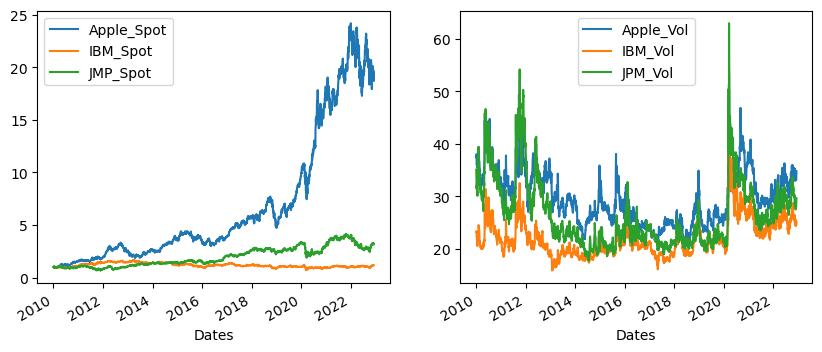

In [10]:
f, ax = plt.subplots(1,2, figsize=(10,4))

(hist_data/hist_data.iloc[0])[['Apple_Spot','IBM_Spot','JMP_Spot']].plot(ax = ax[0])

hist_data[['Apple_Vol', 'IBM_Vol', 'JPM_Vol']].plot(ax = ax[1])

plt.savefig(PATH_FIGS + 'Mkt_data.pdf')

### Computation of 1d and 10d schocks

In [11]:
risk_horizon = 10
hist_data_length = 250

hist_schocks_10d = pd.DataFrame(data = np.log(hist_data.iloc[risk_horizon:].values/ hist_data.iloc[0:-risk_horizon].values),
                            index =  hist_data.index[risk_horizon:], columns = hist_data.columns)

hist_schocks_10d = hist_schocks_10d.iloc[-hist_data_length:]

hist_schocks_1d = pd.DataFrame(data = np.log(hist_data.iloc[1:].values/ hist_data.iloc[0:-1].values),
                            index =  hist_data.index[1:], columns = hist_data.columns)

hist_schocks_1d = hist_schocks_1d.iloc[-hist_data_length:]


### Plot historical schocks. 1d / 10d

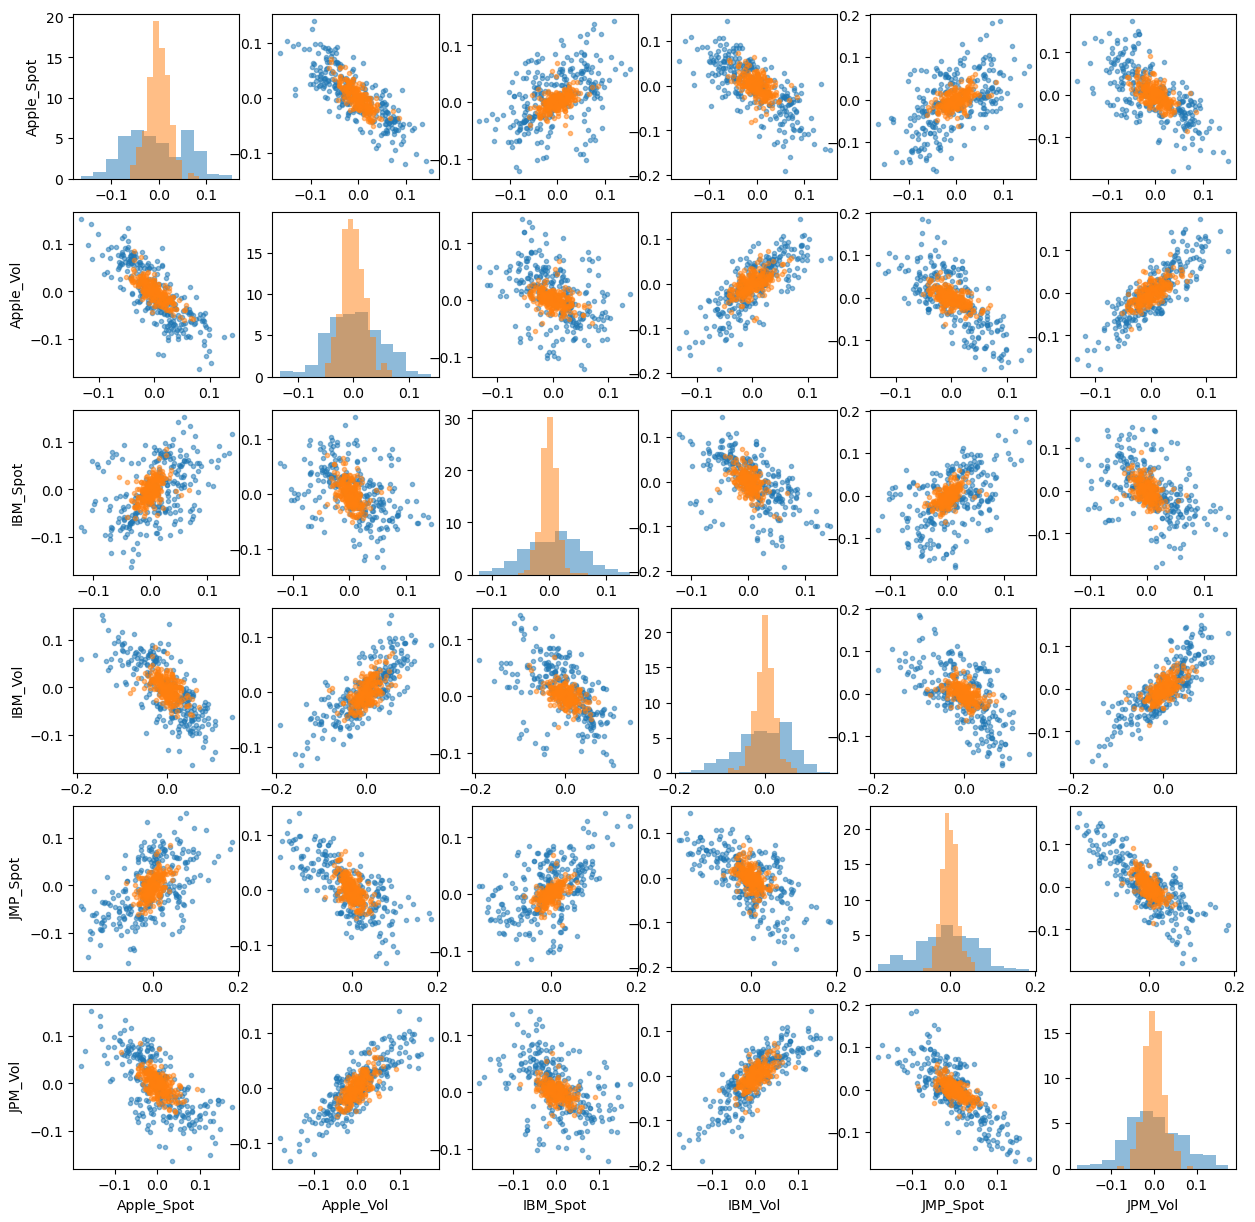

In [12]:
Miscellanea.plot_schocks(6,[hist_schocks_10d.values,hist_schocks_1d.values],hist_schocks_10d.columns,12)

plt.savefig(PATH_FIGS + 'histdata_1d_10d.pdf')

## Calibrate historical data with gaussian mixture and generate training data

In [13]:
num_sims_train = 2**16
num_sims_test = 2**14

gaussian_model_dict = {
    'n_components': 6,
    'gaussian_model_seed': 1234
}

base_scenario_dict = {
    'spot_indexes': [0, 2, 4],
    'spots': [1.0, 1.0, 1.0],
    'vol_indexes': [1, 3, 5],
    'vols': [0.2, 0.3, 0.15],
    'correlations': [[1.0, 0.6, 0.4], [0.6, 1.0, 0.7], [0.4, 0.7, 1.0]],
    'rfr': 0.01,
    'divs': 0.0
}

simulation_dict = {
    'number_of_scenarios': num_sims_train + num_sims_test,
    'shocks_generation_option': Enums.MktRisk_Scenarios_Generation_Option.EXPONENTIAL,
    'tf_generation_option': Enums.Include_Tensorflow_Calcs_option.YES,
    'simulation_seed': 5678,
    'Simulate_Var_Red_Payoff': Enums.Simulate_Var_Red_Payoff.NO
}

indiv_strikes = [1.0, 1.0, 1.0]
option_strike = 1.0

contract_data_dict = {
    'ttm': 3.0,
    'payoff': lambda spot_t: Scenario_Simulation.basket_option(
        spot_t,
        indiv_strikes=indiv_strikes,
        option_strike=option_strike,
        tf_option=simulation_dict['tf_generation_option']
    )
}

dict_1d_results = Scenario_Simulation.calibrate_hist_data_simulate_training_data(
        gaussian_model_dict= gaussian_model_dict, base_scenario_dict= base_scenario_dict,
        simulation_dict= simulation_dict, contract_data_dict= contract_data_dict,
        hist_schocks_data= hist_schocks_1d.values)

gaussian_model_dict['gaussian_model_seed'] = 91011
simulation_dict['simulation_seed'] = 123321


dict_10d_results = Scenario_Simulation.calibrate_hist_data_simulate_training_data(
        gaussian_model_dict= gaussian_model_dict, base_scenario_dict= base_scenario_dict,
        simulation_dict= simulation_dict, contract_data_dict= contract_data_dict,
        hist_schocks_data= hist_schocks_10d.values)

train_data_keys = ['sim_scenario_levels', 'payoff', 'pathwise_derivs']

dict_1d_results_train = {k:dict_1d_results[k] for k in train_data_keys}
dict_10d_results_train = {k:dict_10d_results[k] for k in train_data_keys}


dict_mixed_data_train = Miscellanea.shuffle_arrays_in_dict(
    Miscellanea.concat_dict_containing_np_arrays([dict_1d_results_train,dict_10d_results_train]))

del dict_1d_results_train
del dict_10d_results_train



C:\Users\lmanu\anaconda3\envs\definitive\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\lmanu\anaconda3\envs\definitive\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



### Plot synthetic data + real data

#### 1 day shocks

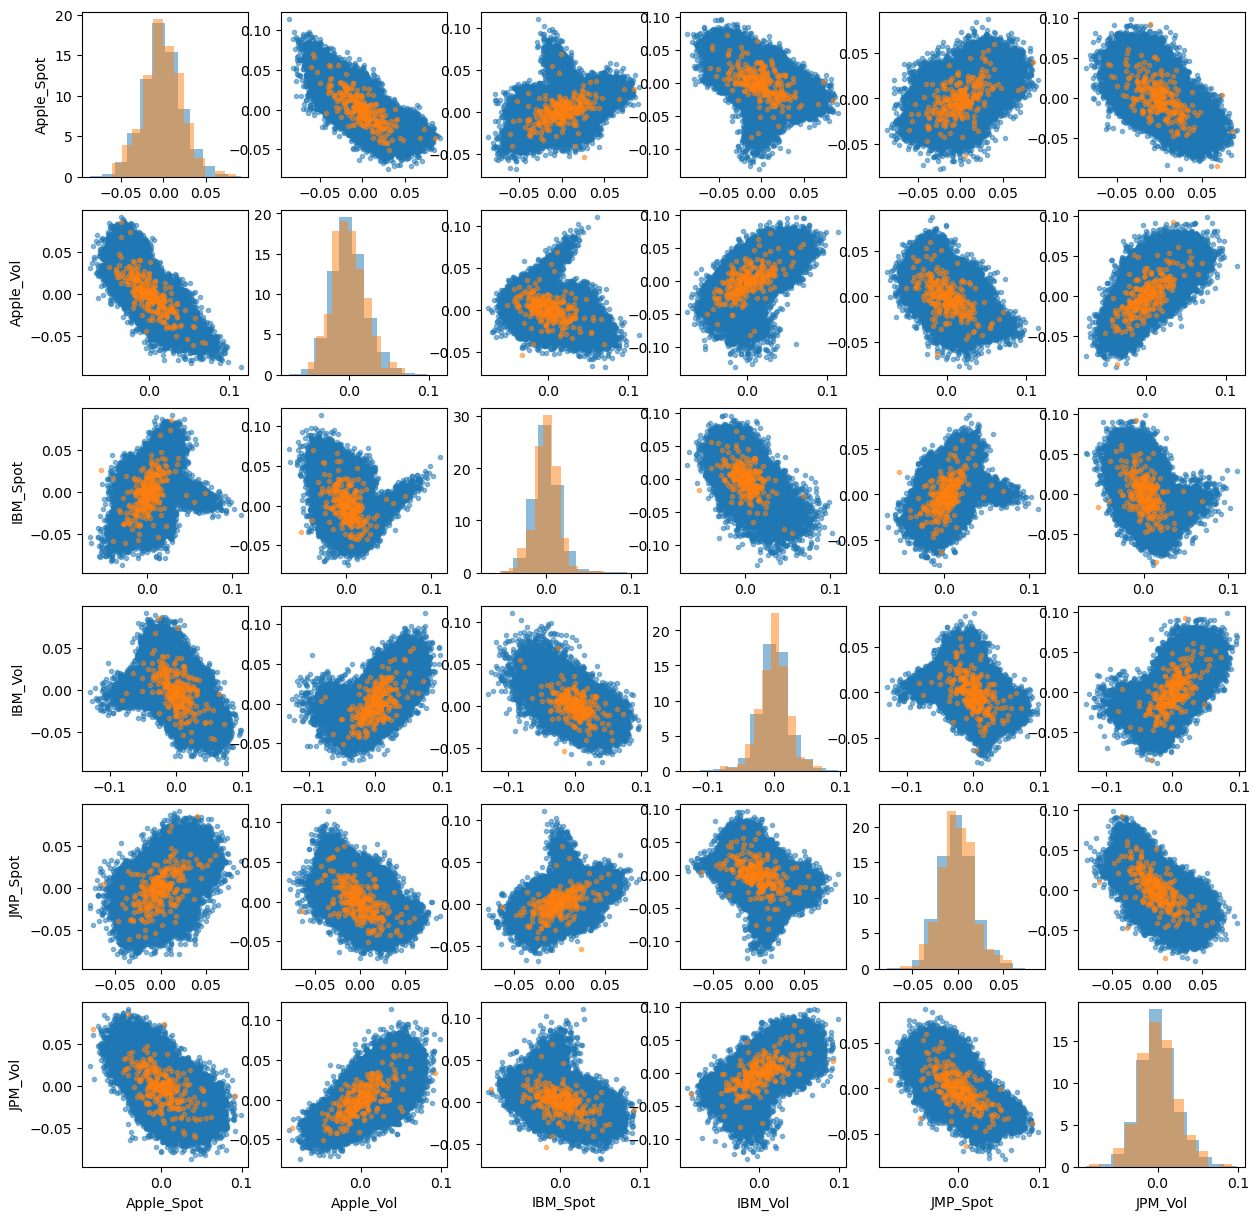

In [14]:
Miscellanea.plot_schocks(6,[dict_1d_results['sim_scenario_shifts'], hist_schocks_1d.values],hist_schocks_1d.columns,12)

#### 10 day schocks

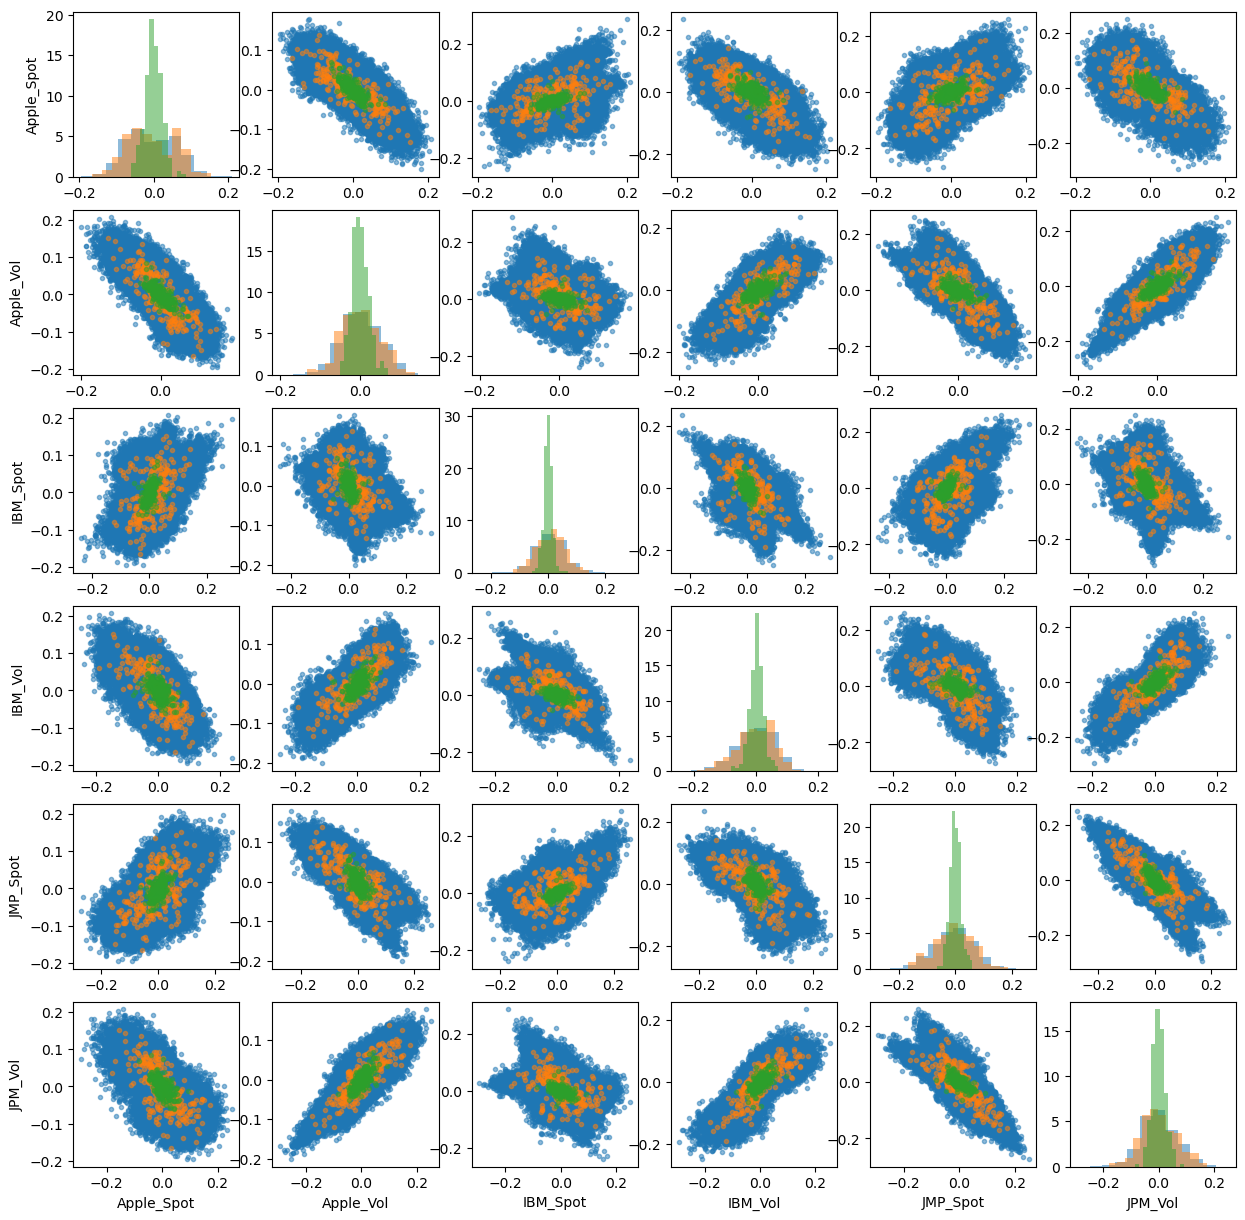

In [15]:
Miscellanea.plot_schocks(6,[dict_10d_results['sim_scenario_shifts'], hist_schocks_10d.values, hist_schocks_1d.values],hist_schocks_1d.columns,12)

### Compute closed form formulas for different scenarios (inc base with sensitivities)

In [16]:
train_range = np.arange(0,num_sims_train)
# train_range_reduced = np.arange(0,2**14)
test_range = np.arange(num_sims_train,num_sims_train + num_sims_test)

base_scenario = dict_1d_results['base_scenario']


payoff_sim = dict_mixed_data_train['payoff']

closed_form_sim_scenario_levels = Option_formulas.BasketOptionVectorized(3,
                dict_mixed_data_train['sim_scenario_levels'][:,base_scenario_dict['spot_indexes']],
                indiv_strikes, option_strike,
                base_scenario_dict['rfr'] * np.ones(3), base_scenario_dict['rfr'],
                base_scenario_dict['divs'] * np.ones(3),
                dict_mixed_data_train['sim_scenario_levels'][:,base_scenario_dict['vol_indexes']],
                np.array(base_scenario_dict['correlations']),
                contract_data_dict['ttm'] , True).numpy()

closed_form_hist_scenario_levels_1d = Option_formulas.BasketOptionVectorized(3,
                dict_1d_results['hist_scenario_levels'][:,base_scenario_dict['spot_indexes']],
                indiv_strikes, option_strike,
                base_scenario_dict['rfr'] * np.ones(3), base_scenario_dict['rfr'],
                base_scenario_dict['divs'] * np.ones(3),
                dict_1d_results['hist_scenario_levels'][:,base_scenario_dict['vol_indexes']],
                np.array(base_scenario_dict['correlations']),
                contract_data_dict['ttm'] , True).numpy()

closed_form_hist_scenario_levels_10d = Option_formulas.BasketOptionVectorized(3,
                dict_10d_results['hist_scenario_levels'][:,base_scenario_dict['spot_indexes']],
                indiv_strikes, option_strike,
                base_scenario_dict['rfr'] * np.ones(3), base_scenario_dict['rfr'],
                base_scenario_dict['divs'] * np.ones(3),
                dict_10d_results['hist_scenario_levels'][:,base_scenario_dict['vol_indexes']],
                np.array(base_scenario_dict['correlations']),
                contract_data_dict['ttm'] , True).numpy()


base_scenario_TF = tf.constant(dict_1d_results['base_scenario'])

with tf.GradientTape() as tape:

    tape.watch(base_scenario_TF)

    closed_form_base = Option_formulas.BasketOptionVectorized(3,
            base_scenario_TF.reshape(1,-1)[:,base_scenario_dict['spot_indexes']],
            indiv_strikes, option_strike, base_scenario_dict['rfr'] * np.ones(3),
            base_scenario_dict['rfr'], base_scenario_dict['divs'] * np.ones(3),
            base_scenario_TF.reshape(1,-1)[:,base_scenario_dict['vol_indexes']],
            np.array(base_scenario_dict['correlations']),
            contract_data_dict['ttm'] , True)

  
sens_base_scenario = tape.gradient(closed_form_base, base_scenario_TF).numpy()

closed_form_base = closed_form_base.numpy()[0]

## Hedge calculations

In [17]:
TTM_Hedge = 0.5


call_A = lambda MktData: Option_formulas.BlackScholesTF(MktData[:,base_scenario_dict['spot_indexes'][0]],
                                                        indiv_strikes[0] , TTM_Hedge, base_scenario_dict['rfr'],
                                                        base_scenario_dict['divs'],
                                                        MktData[:,base_scenario_dict['vol_indexes'][0]], True)
Fut_A = lambda MktData: Option_formulas.FutureTF(MktData[:,base_scenario_dict['spot_indexes'][0]], indiv_strikes[0],
                                                 TTM_Hedge, base_scenario_dict['rfr'],
                                                        base_scenario_dict['divs'])

call_B = lambda MktData: Option_formulas.BlackScholesTF(MktData[:,base_scenario_dict['spot_indexes'][1]],
                                                        indiv_strikes[1] , TTM_Hedge, base_scenario_dict['rfr'],
                                                        base_scenario_dict['divs'],
                                                        MktData[:,base_scenario_dict['vol_indexes'][1]], True)
Fut_B = lambda MktData: Option_formulas.FutureTF(MktData[:,base_scenario_dict['spot_indexes'][1]], indiv_strikes[1],
                                                 TTM_Hedge, base_scenario_dict['rfr'],
                                                        base_scenario_dict['divs'])

call_C = lambda MktData: Option_formulas.BlackScholesTF(MktData[:,base_scenario_dict['spot_indexes'][2]],
                                                        indiv_strikes[2] , TTM_Hedge, base_scenario_dict['rfr'],
                                                        base_scenario_dict['divs'],
                                                        MktData[:,base_scenario_dict['vol_indexes'][2]], True)
Fut_C = lambda MktData: Option_formulas.FutureTF(MktData[:,base_scenario_dict['spot_indexes'][2]], indiv_strikes[2],
                                                 TTM_Hedge, base_scenario_dict['rfr'],
                                                        base_scenario_dict['divs'])



exot = lambda MktData: Option_formulas.BasketOptionVectorized(3, MktData[:,base_scenario_dict['spot_indexes']],
                indiv_strikes, option_strike,
                  base_scenario_dict['rfr']*np.ones(3), base_scenario_dict['rfr'],
                  base_scenario_dict['divs']*np.ones(3),
                  MktData[:,base_scenario_dict['vol_indexes']], base_scenario_dict['correlations'],
                  contract_data_dict['ttm'], True)

# hedge_elements = [Fut_A, call_A, Fut_B, call_B, Fut_C, call_C]

# hedge_elements = [Fut_A, Fut_B, Fut_C]

hedge_elements = [Fut_A, Fut_B, Fut_C, call_A, call_B, call_C]


hedge = Option_formulas.Basket(hedge_elements, exot)

hedge.compute_hedge(base_scenario)


In [18]:
hedge_base = hedge.value_basket(base_scenario)

hedge_sim_data_PL_inc = hedge.value_basket(dict_mixed_data_train['sim_scenario_levels']) - hedge_base

hedge_1d_NPV = hedge.value_basket(dict_1d_results['hist_scenario_levels'])

hedge_1d_PL_inc = hedge_1d_NPV - hedge_base

hedge_10d_PL_inc = hedge.value_basket(dict_10d_results['hist_scenario_levels']) - hedge_base


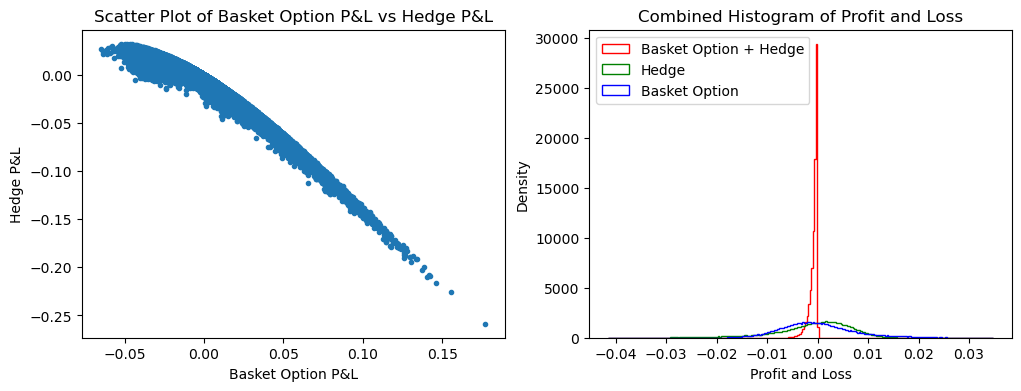

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming exot, my_basket, rf_levels_sim, and base_scenario are defined elsewhere in your code

bins = 250
# Create a figure with two subplots
plt.figure(figsize=(12, 4))

# First subplot for the combined line histograms
plt.subplot(1, 2, 2)  # 2 rows, 1 column, first plot

# Combine the three histograms into a single plt.hist call with line style
plt.hist([exot(dict_1d_results['sim_scenario_levels']).numpy()-exot(base_scenario.reshape(1,-1)).numpy(),
          hedge.value_basket(dict_1d_results['sim_scenario_levels'])-hedge.value_basket(base_scenario),
          (exot(dict_1d_results['sim_scenario_levels']).numpy()-exot(base_scenario.reshape(1,-1)).numpy()) +
          (hedge.value_basket(dict_1d_results['sim_scenario_levels'])-hedge.value_basket(base_scenario))],
         bins=bins, histtype='step', label=['Basket Option', 'Hedge', 'Basket Option + Hedge'],
         color=['blue', 'green', 'red'])

plt.xlabel('Profit and Loss')
plt.ylabel('Density')
# plt.yscale('log')

plt.title('Combined Histogram of Profit and Loss')
plt.legend()

# Second subplot for the scatter plot
plt.subplot(1, 2, 1)  # 2 rows, 1 column, second plot

plt.xlabel('Basket Option P&L')
plt.ylabel('Hedge P&L')
plt.title('Scatter Plot of Basket Option P&L vs Hedge P&L')

plt.plot(exot(dict_mixed_data_train['sim_scenario_levels']).numpy()-exot(base_scenario.reshape(1,-1)).numpy(),
         hedge.value_basket(dict_mixed_data_train['sim_scenario_levels'])-hedge.value_basket(base_scenario), '.')

# Save the figure
plt.savefig(PATH_FIGS + 'hedge_histogram_combined_lines.png')

plt.show()


## -----------------------------------NAIVE APPROACH-----------------------------------------------------

## <span style="color:red">-----------------Train Models (beware of the options)---------------.</span>

### Models fitted to 10d data

In [ ]:
train_range = np.arange(0,num_sims_train)
# train_range_reduced = np.arange(0,2**14)
test_range = np.arange(num_sims_train,num_sims_train + num_sims_test)

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64]
num_hidden_layers = [1, 2, 3]

# PATH_MODELS = 'MODELS/RED_SIMS_NO_EARLY/'
# PATH_MODELS = 'MODELS/EARLY/'
PATH_MODELS = 'MODELS/MODELS_10D/'
# PATH_MODELS = 'MODELS/RED_SIMS_EARLY/'
# PATH_MODELS = 'MODELS/BORRA/'

batch_size = 32
valid_data = None
epochs = 20


ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,'softplus',
              dict_10d_results['sim_scenario_levels'][train_range],
              dict_10d_results['payoff'][train_range],
              dict_10d_results['pathwise_derivs'][train_range], epochs, batch_size, valid_data)


### Models fitted to 1d data

In [ ]:
PATH_MODELS = 'MODELS/MODELS_1D/'

batch_size = 32
valid_data = None
epochs = 20

ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,'softplus',
              dict_1d_results['sim_scenario_levels'][train_range],
              dict_1d_results['payoff'][train_range],
              dict_1d_results['pathwise_derivs'][train_range], epochs, batch_size, valid_data)

### Models fitted to mixed data

In [ ]:
PATH_MODELS = 'MODELS/MODELS_MIXED2/'

train_range = np.arange(0,num_sims_train)
test_range = np.arange(num_sims_train,num_sims_train + num_sims_test)

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64, 128]
num_hidden_layers = [1, 2, 3]

ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,'softplus',
              dict_mixed_data_train['sim_scenario_levels'][train_range],
              dict_mixed_data_train['payoff'][train_range],
              dict_mixed_data_train['pathwise_derivs'][train_range], epochs, batch_size, valid_data)

## <span style="color:red">-----------------End of model train---------------.</span>

### Load saved models

In [ ]:
# PATH_MODELS = 'MODELS/MODELS_1D/'
# PATH_MODELS = 'MODELS/MODELS_10D/'
PATH_MODELS = 'MODELS/MODELS_MIXED/'


alphas = [0, 0.1, 0.5, 1.0, 10.0]
# cells_layer = [64]
# num_hidden_layers = [3]
cells_layer = [32, 64]
num_hidden_layers = [1, 2, 3]

models = ModelHandlers.load_models(PATH_MODELS, alphas, cells_layer, num_hidden_layers)



### Compute metrics

In [ ]:
BASE_SCEN_CTRL_VAR = False


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
#     adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV_PLUS_SENS

else:
    model_adj_train = - closed_form_base
    model_adj_test = - closed_form_base
    adjust_model_with_base_scenario = adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NO


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base,
                     'model_adj': model_adj_test}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base,
                   'model_adj': model_adj_test}]



metrics, best_model_metrics_naive,best_model_zero_alpha_metrics_naive = ModelHandlers.compute_model_metrics(
                    models, alphas, cells_layer, num_hidden_layers,
                    dict_mixed_data_train['sim_scenario_levels'][train_range], payoff_sim[train_range],
                    dict_mixed_data_train['sim_scenario_levels'][test_range],
                    payoff_sim[test_range],
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train, model_adj_test,
                    test_scenarios_data, adjust_model_with_base_scenario);




In [ ]:
table_best_models = pd.DataFrame(data = np.zeros((2,6)), index = ['Best Model', 'Best Model $\lambda = 0.0$'], 
                                 columns = ['nb\_h', 'nb\_c', '$\lambda$', 'mse', 'ks', 'rank'])

table_best_models.loc['Best Model', 'nb\_h'] = best_model_metrics_naive ['model_params']['hidden']
table_best_models.loc['Best Model', 'nb\_c'] = best_model_metrics_naive['model_params']['cells']
table_best_models.loc['Best Model', '$\lambda$'] = best_model_metrics_naive['model_params']['alpha']
table_best_models.loc['Best Model', 'mse'] = best_model_metrics_naive['mse_cv']
table_best_models.loc['Best Model', 'ks'] = best_model_metrics_naive['ks_1d']
table_best_models.loc['Best Model', 'rank'] = best_model_metrics_naive['spearman_1d']

table_best_models.loc['Best Model $\lambda = 0.0$', 'nb\_h'] = best_model_zero_alpha_metrics_naive['model_params']['hidden']
table_best_models.loc['Best Model $\lambda = 0.0$', 'nb\_c'] = best_model_zero_alpha_metrics_naive['model_params']['cells']
table_best_models.loc['Best Model $\lambda = 0.0$', '$\lambda$'] = best_model_zero_alpha_metrics_naive['model_params']['alpha']
table_best_models.loc['Best Model $\lambda = 0.0$', 'mse'] = best_model_zero_alpha_metrics_naive['mse_cv']
table_best_models.loc['Best Model $\lambda = 0.0$', 'ks'] = best_model_zero_alpha_metrics_naive['ks_1d']
table_best_models.loc['Best Model $\lambda = 0.0$', 'rank'] = best_model_zero_alpha_metrics_naive['spearman_1d']

formatters = {
    'nb\_h': lambda x: f'{round(x):d}',  
    'nb\_c': lambda x: f'{round(x):d}',  
    '$\lambda$': lambda x: f'{x:.1f}',
    'mse': lambda x: f'{x:.4f}',  
    'ks': lambda x: f'{x:.4f}',  
    'rank': lambda x: f'{x:.4f}',  
}


print(table_best_models.to_latex(formatters=formatters))

display(table_best_models)



In [ ]:
f,_,_ = Miscellanea.plot_plat_charts(best_model_metrics_naive['cv_scenarios_closed_form_1d'],
                             best_model_metrics_naive['cv_scenarios_model_results_plus_adjustments_1d']);

f.savefig(PATH_FIGS + 'plat_charts_naive.pdf')

In [ ]:
BASE_SCEN_CTRL_VAR = True


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV
    # adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV_PLUS_SENS

else:
    model_adj_train = - closed_form_base
    model_adj_test = - closed_form_base
    adjust_model_with_base_scenario = adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NO


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base,
                     'model_adj': model_adj_test}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base,
                   'model_adj': model_adj_test}]



metrics, best_model_metrics_npv,best_model_zero_alpha_metrics_npv = ModelHandlers.compute_model_metrics(
                    models, alphas, cells_layer, num_hidden_layers,
                    dict_mixed_data_train['sim_scenario_levels'][train_range], payoff_sim[train_range],
                    dict_mixed_data_train['sim_scenario_levels'][test_range],
                    payoff_sim[test_range],
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train, model_adj_test,
                    test_scenarios_data, adjust_model_with_base_scenario);


In [ ]:
f,_,_ = Miscellanea.plot_plat_charts(best_model_metrics_npv['cv_scenarios_closed_form_1d'],
                             best_model_metrics_npv['cv_scenarios_model_results_plus_adjustments_1d']);

f.savefig(PATH_FIGS + 'plat_charts_npv.pdf')

In [ ]:
BASE_SCEN_CTRL_VAR = True


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
    # adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV_PLUS_SENS

else:
    model_adj_train = - closed_form_base
    model_adj_test = - closed_form_base
    adjust_model_with_base_scenario = adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NO


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base,
                     'model_adj': model_adj_test}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base,
                   'model_adj': model_adj_test}]



metrics, best_model_metrics_sens,best_model_zero_alpha_metrics_sens = ModelHandlers.compute_model_metrics(
                    models, alphas, cells_layer, num_hidden_layers,
                    dict_mixed_data_train['sim_scenario_levels'][train_range], payoff_sim[train_range],
                    dict_mixed_data_train['sim_scenario_levels'][test_range],
                    payoff_sim[test_range],
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train, model_adj_test,
                    test_scenarios_data, adjust_model_with_base_scenario);


In [ ]:
f,_,_ = Miscellanea.plot_plat_charts(best_model_metrics_sens['cv_scenarios_closed_form_1d'],
                             best_model_metrics_sens['cv_scenarios_model_results_plus_adjustments_1d']);

f.savefig(PATH_FIGS + 'plat_charts_sens.pdf')

### Compute metrics with hedge basket

In [ ]:
BASE_SCEN_CTRL_VAR = False


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base + \
    hedge_sim_data_PL_inc
  
if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV
    # adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV_PLUS_SENS
else:
    model_adj_train = - closed_form_base
    model_adj_test = - closed_form_base
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NO


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base + hedge_1d_PL_inc,
                     'model_adj': model_adj_test + hedge_1d_PL_inc}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base + hedge_10d_PL_inc,
                     'model_adj': model_adj_test + hedge_10d_PL_inc}]

metrics, best_model_metrics_hedged_naive,best_model_zero_alpha_metrics_hedged_naive  = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers,
                    dict_mixed_data_train['sim_scenario_levels'][train_range], payoff_sim[train_range], dict_mixed_data_train['sim_scenario_levels'][test_range], payoff_sim[test_range],
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train + hedge_sim_data_PL_inc[train_range],
                    model_adj_test + hedge_sim_data_PL_inc[test_range],
                    test_scenarios_data, adjust_model_with_base_scenario)



In [ ]:
BASE_SCEN_CTRL_VAR = True


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base + \
    hedge_sim_data_PL_inc
  
if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV
    # adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV_PLUS_SENS
else:
    model_adj_train = - closed_form_base
    model_adj_test = - closed_form_base
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NO


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base + hedge_1d_PL_inc,
                     'model_adj': model_adj_test + hedge_1d_PL_inc}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base + hedge_10d_PL_inc,
                     'model_adj': model_adj_test + hedge_10d_PL_inc}]

metrics, best_model_metrics_hedged_npv,best_model_zero_alpha_metrics_hedged_npv  = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers,
                    dict_mixed_data_train['sim_scenario_levels'][train_range], payoff_sim[train_range], dict_mixed_data_train['sim_scenario_levels'][test_range], payoff_sim[test_range],
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train + hedge_sim_data_PL_inc[train_range],
                    model_adj_test + hedge_sim_data_PL_inc[test_range],
                    test_scenarios_data, adjust_model_with_base_scenario)



In [ ]:
BASE_SCEN_CTRL_VAR = True


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base + \
    hedge_sim_data_PL_inc
  
if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
    # adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV_PLUS_SENS
else:
    model_adj_train = - closed_form_base
    model_adj_test = - closed_form_base
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NO


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base + hedge_1d_PL_inc,
                     'model_adj': model_adj_test + hedge_1d_PL_inc}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base + hedge_10d_PL_inc,
                     'model_adj': model_adj_test + hedge_10d_PL_inc}]

metrics, best_model_metrics_hedged_sens,best_model_zero_alpha_metrics_hedged_sens  = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers,
                    dict_mixed_data_train['sim_scenario_levels'][train_range], payoff_sim[train_range], dict_mixed_data_train['sim_scenario_levels'][test_range], payoff_sim[test_range],
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train + hedge_sim_data_PL_inc[train_range],
                    model_adj_test + hedge_sim_data_PL_inc[test_range],
                    test_scenarios_data, adjust_model_with_base_scenario)



In [ ]:
import pandas as pd

# Create a list of tuples representing the multi-level column names
columns = pd.MultiIndex.from_tuples([
    ('Unhedged', 'ks'),
    ('Unhedged', 'Rank'),
    ('Hedged', 'ks'),
    ('Hedged', 'Rank'),
])

index = ['NPV $\lambda = 0.0$', 'NPV $\lambda = 1.0$', 'SENS $\lambda = 0.0$', 'SENS $\lambda = 1.0$']

# Create some example data
data = np.zeros((len(index), len(columns)))

# Create the DataFrame
table_model_comp = pd.DataFrame(data, columns=columns, index = index)

table_model_comp.loc['NPV $\lambda = 0.0$',('Unhedged', 'ks')] = best_model_zero_alpha_metrics_npv['ks_1d']
table_model_comp.loc['NPV $\lambda = 0.0$',('Unhedged', 'Rank')] = best_model_zero_alpha_metrics_npv['spearman_1d']
table_model_comp.loc['NPV $\lambda = 0.0$',('Hedged', 'ks')] = best_model_zero_alpha_metrics_hedged_npv['ks_1d']
table_model_comp.loc['NPV $\lambda = 0.0$',('Hedged', 'Rank')] = best_model_zero_alpha_metrics_hedged_npv['spearman_1d']

table_model_comp.loc['NPV $\lambda = 1.0$',('Unhedged', 'ks')] = best_model_metrics_npv['ks_1d']
table_model_comp.loc['NPV $\lambda = 1.0$',('Unhedged', 'Rank')] = best_model_metrics_npv['spearman_1d']
table_model_comp.loc['NPV $\lambda = 1.0$',('Hedged', 'ks')] = best_model_metrics_hedged_npv['ks_1d']
table_model_comp.loc['NPV $\lambda = 1.0$',('Hedged', 'Rank')] = best_model_metrics_hedged_npv['spearman_1d']

table_model_comp.loc['SENS $\lambda = 0.0$',('Unhedged', 'ks')] = best_model_zero_alpha_metrics_sens['ks_1d']
table_model_comp.loc['SENS $\lambda = 0.0$',('Unhedged', 'Rank')] = best_model_zero_alpha_metrics_sens['spearman_1d']
table_model_comp.loc['SENS $\lambda = 0.0$',('Hedged', 'ks')] = best_model_zero_alpha_metrics_hedged_sens['ks_1d']
table_model_comp.loc['SENS $\lambda = 0.0$',('Hedged', 'Rank')] = best_model_zero_alpha_metrics_hedged_sens['spearman_1d']

table_model_comp.loc['SENS $\lambda = 1.0$',('Unhedged', 'ks')] = best_model_metrics_sens['ks_1d']
table_model_comp.loc['SENS $\lambda = 1.0$',('Unhedged', 'Rank')] = best_model_metrics_sens['spearman_1d']
table_model_comp.loc['SENS $\lambda = 1.0$',('Hedged', 'ks')] = best_model_metrics_hedged_sens['ks_1d']
table_model_comp.loc['SENS $\lambda = 1.0$',('Hedged', 'Rank')] = best_model_metrics_hedged_sens['spearman_1d']

# Show the DataFrame
print(table_model_comp.to_latex())

display(table_model_comp)


In [ ]:
f,_,_ = Miscellanea.plot_plat_charts(best_model_metrics_hedged_naive['cv_scenarios_closed_form_1d'],
                             best_model_metrics_hedged_naive['cv_scenarios_model_results_plus_adjustments_1d']);

f.savefig(PATH_FIGS + 'plat_charts_sens.pdf')

In [ ]:
f,_,_ = Miscellanea.plot_plat_charts(best_model_metrics_hedged_npv['cv_scenarios_closed_form_1d'],
                             best_model_metrics_hedged_npv['cv_scenarios_model_results_plus_adjustments_1d']);

f.savefig(PATH_FIGS + 'plat_charts_sens.pdf')

In [ ]:
f,_,_ = Miscellanea.plot_plat_charts(best_model_metrics_hedged_sens['cv_scenarios_closed_form_1d'],
                             best_model_metrics_hedged_sens['cv_scenarios_model_results_plus_adjustments_1d']);

f.savefig(PATH_FIGS + 'plat_charts_sens.pdf')

### Simulation of scenarios computing variance reduction

In [ ]:
simulation_dict['Simulate_Var_Red_Payoff'] = Enums.Simulate_Var_Red_Payoff.YES


gaussian_model_dict['gaussian_model_seed'] = 1234
simulation_dict['simulation_seed'] = 5678

dict_1d_results_VR = Scenario_Simulation.calibrate_hist_data_simulate_training_data(
        gaussian_model_dict= gaussian_model_dict, base_scenario_dict= base_scenario_dict,
        simulation_dict= simulation_dict, contract_data_dict= contract_data_dict,
        hist_schocks_data= hist_schocks_1d.   values)



gaussian_model_dict['gaussian_model_seed'] = 91011
simulation_dict['simulation_seed'] = 123321



dict_10d_results_VR = Scenario_Simulation.calibrate_hist_data_simulate_training_data(
        gaussian_model_dict= gaussian_model_dict, base_scenario_dict= base_scenario_dict,
        simulation_dict= simulation_dict, contract_data_dict= contract_data_dict,
        hist_schocks_data= hist_schocks_10d.values)

dict_1d_results_train = {k:dict_1d_results_VR[k] for k in train_data_keys}
dict_10d_results_train = {k:dict_10d_results_VR[k] for k in train_data_keys}


dict_mixed_data_train_VR = Miscellanea.shuffle_arrays_in_dict(
    Miscellanea.concat_dict_containing_np_arrays([dict_1d_results_train,dict_10d_results_train]))

del dict_1d_results_train
del dict_10d_results_train





In [ ]:

  
plt.hist([dict_1d_results_VR['payoff'], dict_1d_results['payoff']],
    bins = 100,density = True, stacked = False, histtype = 'stepfilled', label = ['No Variance Reduction','Variance Reduction'] ,alpha = 0.5)
plt.xlabel('Model label values')
plt.ylabel('Probability')

plt.yscale('log')

plt.savefig(PATH_FIGS + 'VR.pdf');


### <span style="color:red">-----------------Train Models VR (beware of the options)---------------.</span>

## Models fitted to mixed data

In [ ]:
train_range = np.arange(0,num_sims_train)
# train_range_reduced = np.arange(0,2**14)
test_range = np.arange(num_sims_train,num_sims_train + num_sims_test)

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64]
num_hidden_layers = [1, 2, 3]
# cells_layer = [64]
# num_hidden_layers = [3]
# num_hidden_layers = [1]


PATH_MODELS = 'MODELS_VR/MODELS_MIXED/'


batch_size = 32
valid_data = None
epochs = 20


ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,'softplus',
              dict_mixed_data_train_VR['sim_scenario_levels'][train_range],
              dict_mixed_data_train_VR['payoff'][train_range],
              dict_mixed_data_train_VR['pathwise_derivs'][train_range], epochs, batch_size, valid_data)


## <span style="color:red">-----------------End of model train---------------.</span>

### Load models data for variance reduction

In [ ]:
# PATH_MODELS = 'MODELS_VR/MODELS_1D/'
# PATH_MODELS = 'MODELS_VR/MODELS_10D/'
PATH_MODELS = 'MODELS_VR/MODELS_MIXED/'

alphas = [0, 0.1, 0.5, 1.0, 10.0]
# cells_layer = [64]
# num_hidden_layers = [3]
cells_layer = [32, 64]
num_hidden_layers = [1, 2, 3]

models = ModelHandlers.load_models(PATH_MODELS, alphas, cells_layer, num_hidden_layers)


if PATH_MODELS == 'MODELS_VR/MODELS_1D/':
    rf_levels_sim = dict_1d_results['sim_scenario_levels']
    payoff_sim = dict_1d_results['payoff']
elif PATH_MODELS == 'MODELS_VR/MODELS_10D/':
    rf_levels_sim = dict_10d_results['sim_scenario_levels']
    payoff_sim = dict_10d_results['payoff']
elif PATH_MODELS == 'MODELS_VR/MODELS_MIXED/':
    rf_levels_sim = dict_mixed_data_train['sim_scenario_levels']
    payoff_sim = dict_mixed_data_train['payoff']

closed_form_sim_scenario_levels = Option_formulas.BasketOptionVectorized(3,
                rf_levels_sim[:,base_scenario_dict['spot_indexes']],
                indiv_strikes, option_strike,
                base_scenario_dict['rfr'] * np.ones(3), base_scenario_dict['rfr'],
                base_scenario_dict['divs'] * np.ones(3),
                rf_levels_sim[:,base_scenario_dict['vol_indexes']],
                np.array(base_scenario_dict['correlations']),
                contract_data_dict['ttm'] , True).numpy()

### Compute metrics (no hedge)

In [ ]:
BASE_SCEN_CTRL_VAR = True


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV
    # adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV_PLUS_SENS
else:
    model_adj_train = - 0
    model_adj_cv = - 0
    model_adj_test = - 0
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NO


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base,
                     'model_adj': model_adj_test}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base,
                   'model_adj': model_adj_test}]


metrics, best_model_metrics_vr_npv, best_model_zero_alpha_metrics_vr_npv = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers,
                    rf_levels_sim[train_range], payoff_sim[train_range],
                    rf_levels_sim[test_range],
                    payoff_sim[test_range],
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train, model_adj_test,
                    test_scenarios_data, adjust_model_with_base_scenario)



In [ ]:
BASE_SCEN_CTRL_VAR = True


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
    # adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV_PLUS_SENS
else:
    model_adj_train = - 0
    model_adj_cv = - 0
    model_adj_test = - 0
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NO


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base,
                     'model_adj': model_adj_test}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base,
                   'model_adj': model_adj_test}]


metrics, best_model_metrics_vr_sens, best_model_zero_alpha_metrics_vr_sens = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers,
                    rf_levels_sim[train_range], payoff_sim[train_range],
                    rf_levels_sim[test_range],
                    payoff_sim[test_range],
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train, model_adj_test,
                    test_scenarios_data, adjust_model_with_base_scenario)



### Compute metrics (hedge)

In [ ]:
BASE_SCEN_CTRL_VAR = True


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base + \
    hedge_sim_data_PL_inc

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV
    # adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV_PLUS_SENS
else:
    model_adj_train = - 0
    model_adj_test = - 0
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NO


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base + hedge_1d_PL_inc,
                     'model_adj': model_adj_test + hedge_1d_PL_inc}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base + hedge_10d_PL_inc,
                     'model_adj': model_adj_test + hedge_10d_PL_inc}]

metrics, best_model_metrics_vr_hedged_npv,best_model_zero_alpha_metrics_vr_hedged_npv  = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers,
                    rf_levels_sim[train_range], payoff_sim[train_range], rf_levels_sim[test_range], payoff_sim[test_range],
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train + hedge_sim_data_PL_inc[train_range],
                    model_adj_test + hedge_sim_data_PL_inc[test_range],
                    test_scenarios_data, adjust_model_with_base_scenario)

In [ ]:
BASE_SCEN_CTRL_VAR = True


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base + \
    hedge_sim_data_PL_inc

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
    # adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV_PLUS_SENS
else:
    model_adj_train = - 0
    model_adj_test = - 0
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NO


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base + hedge_1d_PL_inc,
                     'model_adj': model_adj_test + hedge_1d_PL_inc}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base + hedge_10d_PL_inc,
                     'model_adj': model_adj_test + hedge_10d_PL_inc}]

metrics, best_model_metrics_vr_hedged_sens,best_model_zero_alpha_metrics_vr_hedged_sens  = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers,
                    rf_levels_sim[train_range], payoff_sim[train_range], rf_levels_sim[test_range], payoff_sim[test_range],
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train + hedge_sim_data_PL_inc[train_range],
                    model_adj_test + hedge_sim_data_PL_inc[test_range],
                    test_scenarios_data, adjust_model_with_base_scenario)

In [ ]:
import pandas as pd

# Create a list of tuples representing the multi-level column names
columns = pd.MultiIndex.from_tuples([
    ('Unhedged', 'ks'),
    ('Unhedged', 'Rank'),
    ('Hedged', 'ks'),
    ('Hedged', 'Rank'),
])

index = ['VR NPV $\lambda = 0.0$', 'VR NPV $\lambda = 0.1$', 'VR SENS $\lambda = 0.0$', 'VR SENS $\lambda = 0.1$']

# Create some example data
data = np.zeros((len(index), len(columns)))

# Create the DataFrame
table_model_comp = pd.DataFrame(data, columns=columns, index = index)

table_model_comp.loc['VR NPV $\lambda = 0.0$',('Unhedged', 'ks')] = best_model_zero_alpha_metrics_vr_npv['ks_1d']
table_model_comp.loc['VR NPV $\lambda = 0.0$',('Unhedged', 'Rank')] = best_model_zero_alpha_metrics_vr_npv['spearman_1d']
table_model_comp.loc['VR NPV $\lambda = 0.0$',('Hedged', 'ks')] = best_model_zero_alpha_metrics_vr_hedged_npv['ks_1d']
table_model_comp.loc['VR NPV $\lambda = 0.0$',('Hedged', 'Rank')] = best_model_zero_alpha_metrics_vr_hedged_npv['spearman_1d']

table_model_comp.loc['VR NPV $\lambda = 0.1$',('Unhedged', 'ks')] = best_model_metrics_vr_npv['ks_1d']
table_model_comp.loc['VR NPV $\lambda = 0.1$',('Unhedged', 'Rank')] = best_model_metrics_vr_npv['spearman_1d']
table_model_comp.loc['VR NPV $\lambda = 0.1$',('Hedged', 'ks')] = best_model_metrics_vr_hedged_npv['ks_1d']
table_model_comp.loc['VR NPV $\lambda = 0.1$',('Hedged', 'Rank')] = best_model_metrics_vr_hedged_npv['spearman_1d']

table_model_comp.loc['VR SENS $\lambda = 0.0$',('Unhedged', 'ks')] = best_model_zero_alpha_metrics_vr_sens['ks_1d']
table_model_comp.loc['VR SENS $\lambda = 0.0$',('Unhedged', 'Rank')] = best_model_zero_alpha_metrics_vr_sens['spearman_1d']
table_model_comp.loc['VR SENS $\lambda = 0.0$',('Hedged', 'ks')] = best_model_zero_alpha_metrics_vr_hedged_sens['ks_1d']
table_model_comp.loc['VR SENS $\lambda = 0.0$',('Hedged', 'Rank')] = best_model_zero_alpha_metrics_vr_hedged_sens['spearman_1d']

table_model_comp.loc['VR SENS $\lambda = 0.1$',('Unhedged', 'ks')] = best_model_metrics_vr_sens['ks_1d']
table_model_comp.loc['VR SENS $\lambda = 0.1$',('Unhedged', 'Rank')] = best_model_metrics_vr_sens['spearman_1d']
table_model_comp.loc['VR SENS $\lambda = 0.1$',('Hedged', 'ks')] = best_model_metrics_vr_hedged_sens['ks_1d']
table_model_comp.loc['VR SENS $\lambda = 0.1$',('Hedged', 'Rank')] = best_model_metrics_vr_hedged_sens['spearman_1d']

# Show the DataFrame
print(table_model_comp.to_latex())

display(table_model_comp)

print(best_model_zero_alpha_metrics_vr_npv['model_params'])
print(best_model_metrics_vr_npv['model_params'])

# Definitive ongoing data

In [20]:
# Data simulation dictionaries:
gaussian_model_dict = {
    'n_examples': 250,
    'n_components': 6,
    'gaussian_model_seed': 1234
}

base_scenario_dict = {
    'spot_indexes': [0, 2, 4],
    'spots': None,
    'vol_indexes': [1, 3, 5],
    'vols': None,
    'correlations': None,
    'rfr': 0.01,
    'divs': 0.0,
    'num_escen_correl_matrix': 250,
    'base_scenario': None
}

simulation_dict = {
    'shocks_generation_option': Enums.MktRisk_Scenarios_Generation_Option.EXPONENTIAL,
    'tf_generation_option': Enums.Include_Tensorflow_Calcs_option.YES,
    'simulation_seed': 5678,
    'Simulate_Var_Red_Payoff': Enums.Simulate_Var_Red_Payoff.NO
}


contract_data_dict = {
    'ttm': None,
    'generic_payoff': lambda indiv_strikes_value: \
                        lambda spot_t: \
                        (Scenario_Simulation.basket_option(spots_t= spot_t,
                            indiv_strikes=indiv_strikes_value,
                            option_strike=1.0,
                            tf_option=Enums.Include_Tensorflow_Calcs_option.YES)- \
                        Scenario_Simulation.basket_option(
                            spot_t,
                            indiv_strikes=indiv_strikes_value,
                            option_strike=1.1,
                            tf_option=Enums.Include_Tensorflow_Calcs_option.YES))/0.1,
    'payoff': None,
    'generic_closed_form_formula': lambda indiv_strikes_value, maturity: \
                            lambda spot_t, vol_t, rfr, divs, correl: \
                            (Option_formulas.BasketOptionVectorized(num_assets = 3,
                                initial_prices = spot_t, strike_prices = indiv_strikes_value,
                                gross_return_strike = 1.0, repo_rates = rfr*np.ones(3),
                                discount_rate = rfr, dividends = divs*np.ones(3),
                                volatilities = vol_t, correlations = correl,
                                time_to_maturity = maturity, IsCall = True) -
                            Option_formulas.BasketOptionVectorized(num_assets = 3,
                                initial_prices = spot_t, strike_prices = indiv_strikes_value,
                                gross_return_strike = 1.1, repo_rates = rfr*np.ones(3),
                                discount_rate = rfr, dividends = divs*np.ones(3),
                                volatilities = vol_t, correlations = correl,
                                time_to_maturity = maturity, IsCall = True))/0.1,
    'closed_form_formula': None,
    'indiv_strikes': None
}


training_data_generation_dict = {
        'gaussian_model_dict' : gaussian_model_dict,
        'base_scenario_dict': base_scenario_dict,
        'simulation_dict': simulation_dict,
        'contract_data_dict': contract_data_dict
    }

machine_learning_models_dict = {
    'nb_hidden_layers': 3,
    'nd_cells_hidden_layer': 64,
    'hidden_layer_activation': 'softplus',
    'output_layer_activation': 'linear',
    'batch_size': 32,
    'num_epochs_payoff_reset': 20,
    'num_epochs_daily_calc': 1,
    'num_training_examples_payoff_reset': 2**16,
    'num_training_examples_daily_calc': 2**14,
    'alpha' : 1.0,
    'verbose': 1,
    'MODELS_PATH': "MODELS/MODELS_MANAGEMENT/3YR_NAIVE_LAMBDA_1_0/",
    'plat_analysis_subfolder': "COMPLETE/"
}


risk_management_dict = {
    'maturity_in_months_at_reset_dates': 36,
    'hedge_maturity_in_years': [None,0.5],
    'end_date': hist_data.index[-1],
    'initial_date': hist_data.index[gaussian_model_dict['n_examples'] + 10],
    'fut_hedge': [[True, True, True]],
    'call_hedge': [[False, False, False], [True, False, False], [True, True, False],[True, True, True]],
    'cvar_conf_level': 0.975
}     

 


In [21]:
mmm = ModelHandlers.plat_orquestrator(training_data_generation_dict, machine_learning_models_dict, risk_management_dict, hist_data)

In [ ]:
mmm.train_models_for_all_dates()

In [ ]:
mmm.run_plat_analysis()

In [22]:
mmm.load_analysis_results()  

Analysis results loaded from MODELS/MODELS_MANAGEMENT/3YR_NAIVE_LAMBDA_1_0/COMPLETE/


In [24]:
df1 = Miscellanea.summarize_ongoing_plat_statistics(mmm,range(4,8))

df1

,Unhedged,Delta Hedged,Delta + 1 vega Hedged,Delta + 2 vega Hedged,Delta + 3 vega Hedged
Avg CVaR,-0.144831,-0.042447,-0.024765,-0.017238,-0.007964
% Green,1.000000,0.934062,0.913297,0.911840,0.395993
% Yellow,0.000000,0.044444,0.050638,0.045902,0.333698
% Red,0.000000,0.021494,0.036066,0.042259,0.270310


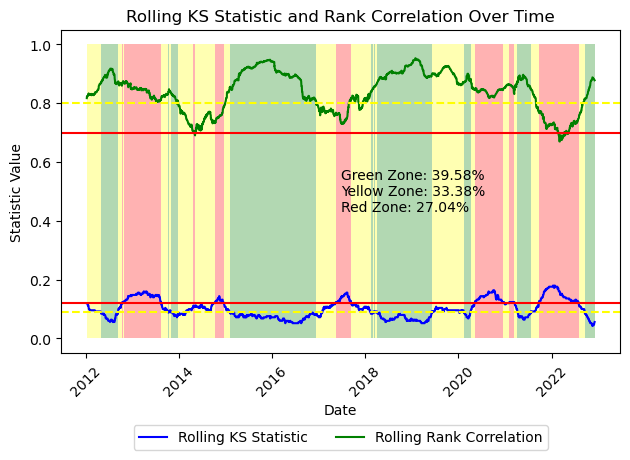

<Figure size 640x480 with 0 Axes>

In [36]:
ind = 7

ks, rk = Miscellanea.compute_rolling_plat_statistic(mmm.hpl_with_hedge[:,ind], mmm.rtpl_sens_with_hedge[:,ind], 250)

# ks, rk = Miscellanea.compute_rolling_plat_statistic(mmm.hpl, mmm.rtpl_sens, 250)

Miscellanea.plot_plat_statistics_with_zones(mmm.dates[250:],ks, rk, PATH_FIGS + 'fut_hedge_ongoing.pdf')


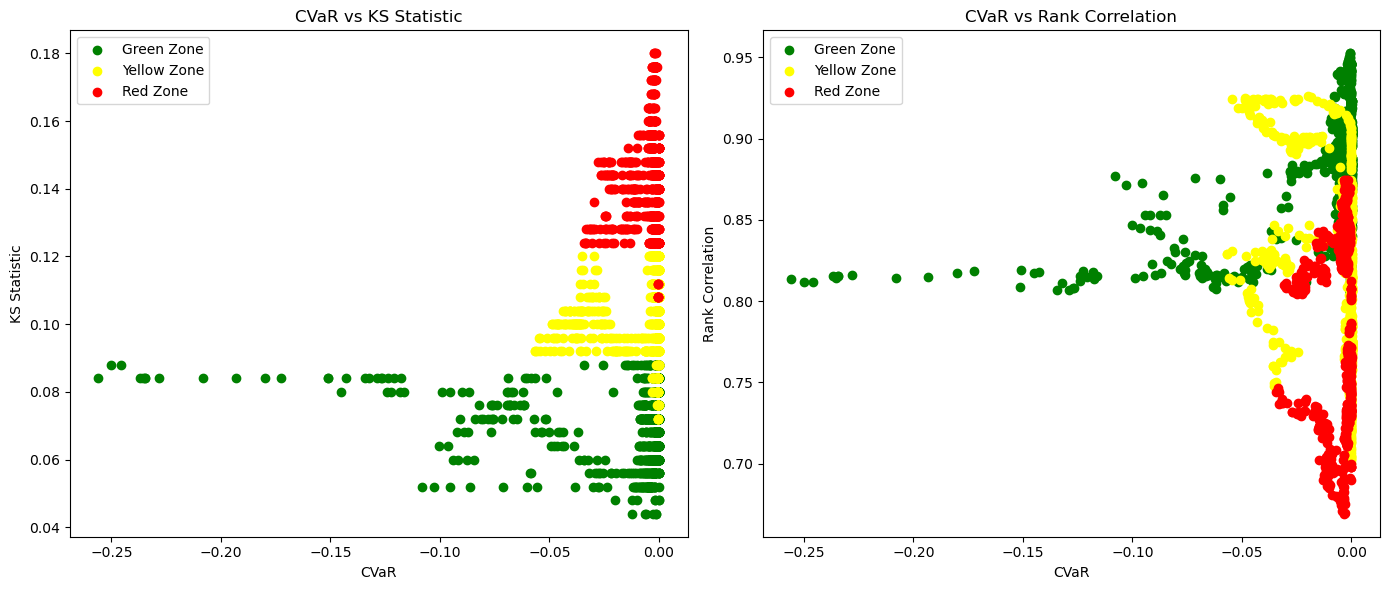

In [37]:
Miscellanea.plat_cvar_scatter(ks,rk,mmm.cvar_with_hedge[250:,ind])

In [43]:
# Data simulation dictionaries:
gaussian_model_dict = {
    'n_examples': 250,
    'n_components': 6,
    'gaussian_model_seed': 1234
}

base_scenario_dict = {
    'spot_indexes': [0, 2, 4],
    'spots': None,
    'vol_indexes': [1, 3, 5],
    'vols': None,
    'correlations': None,
    'rfr': 0.01,
    'divs': 0.0,
    'num_escen_correl_matrix': 250,
    'base_scenario': None
}

simulation_dict = {
    'shocks_generation_option': Enums.MktRisk_Scenarios_Generation_Option.EXPONENTIAL,
    'tf_generation_option': Enums.Include_Tensorflow_Calcs_option.YES,
    'simulation_seed': 5678,
    'Simulate_Var_Red_Payoff': Enums.Simulate_Var_Red_Payoff.YES
}


contract_data_dict = {
    'ttm': None,
    'generic_payoff': lambda indiv_strikes_value: \
                        lambda spot_t: \
                        (Scenario_Simulation.basket_option(spots_t= spot_t,
                            indiv_strikes=indiv_strikes_value,
                            option_strike=1.0,
                            tf_option=Enums.Include_Tensorflow_Calcs_option.YES)- \
                        Scenario_Simulation.basket_option(
                            spot_t,
                            indiv_strikes=indiv_strikes_value,
                            option_strike=1.1,
                            tf_option=Enums.Include_Tensorflow_Calcs_option.YES))/0.1,
    'payoff': None,
    'generic_closed_form_formula': lambda indiv_strikes_value, maturity: \
                            lambda spot_t, vol_t, rfr, divs, correl: \
                            (Option_formulas.BasketOptionVectorized(num_assets = 3,
                                initial_prices = spot_t, strike_prices = indiv_strikes_value,
                                gross_return_strike = 1.0, repo_rates = rfr*np.ones(3),
                                discount_rate = rfr, dividends = divs*np.ones(3),
                                volatilities = vol_t, correlations = correl,
                                time_to_maturity = maturity, IsCall = True) -
                            Option_formulas.BasketOptionVectorized(num_assets = 3,
                                initial_prices = spot_t, strike_prices = indiv_strikes_value,
                                gross_return_strike = 1.1, repo_rates = rfr*np.ones(3),
                                discount_rate = rfr, dividends = divs*np.ones(3),
                                volatilities = vol_t, correlations = correl,
                                time_to_maturity = maturity, IsCall = True))/0.1,
    'closed_form_formula': None,
    'indiv_strikes': None
}


training_data_generation_dict = {
        'gaussian_model_dict' : gaussian_model_dict,
        'base_scenario_dict': base_scenario_dict,
        'simulation_dict': simulation_dict,
        'contract_data_dict': contract_data_dict
    }

machine_learning_models_dict = {
    'nb_hidden_layers': 3,
    'nd_cells_hidden_layer': 64,
    'hidden_layer_activation': 'softplus',
    'output_layer_activation': 'linear',
    'batch_size': 32,
    'num_epochs_payoff_reset': 20,
    'num_epochs_daily_calc': 1,
    'num_training_examples_payoff_reset': 2**16,
    'num_training_examples_daily_calc': 2**14,
    'alpha' : 0.1,
    'verbose': 1,
    'MODELS_PATH': "MODELS/MODELS_MANAGEMENT/3YR_VR_LAMBDA_0_1/",
    'plat_analysis_subfolder': "COMPLETE/"
}


risk_management_dict = {
    'maturity_in_months_at_reset_dates': 36,
    'hedge_maturity_in_years': [0.5],
    'end_date': hist_data.index[-1],
    'initial_date': hist_data.index[gaussian_model_dict['n_examples'] + 10],
    'fut_hedge': [[True, True, True]],
    'call_hedge': [[False, False, False], [True, False, False], [True, True, False],[True, True, True]],
    'cvar_conf_level': 0.975
}     

mmm = ModelHandlers.plat_orquestrator(training_data_generation_dict, machine_learning_models_dict, risk_management_dict, hist_data) 


In [ ]:
mmm.train_models_for_all_dates()

In [ ]:
mmm.continue_training_models()

In [ ]:
mmm.run_plat_analysis()

In [44]:
mmm.load_analysis_results()

Analysis results loaded from MODELS/MODELS_MANAGEMENT/3YR_VR_LAMBDA_0_1/COMPLETE/


In [45]:
df = Miscellanea.summarize_ongoing_plat_statistics(mmm, range(4))

df

,Unhedged,Delta Hedged,Delta + 1 vega Hedged,Delta + 2 vega Hedged,Delta + 3 vega Hedged
Avg CVaR,-0.144969,-0.042472,-0.024836,-0.017246,-0.007989
% Green,1.000000,0.978871,0.943898,0.822587,0.252459
% Yellow,0.000000,0.021129,0.056102,0.106740,0.258652
% Red,0.000000,0.000000,0.000000,0.070674,0.488889


In [ ]:
mmm.hpl_with_hedge

0.10477814207650273
0.7439873519039726
-0.007989026979057678


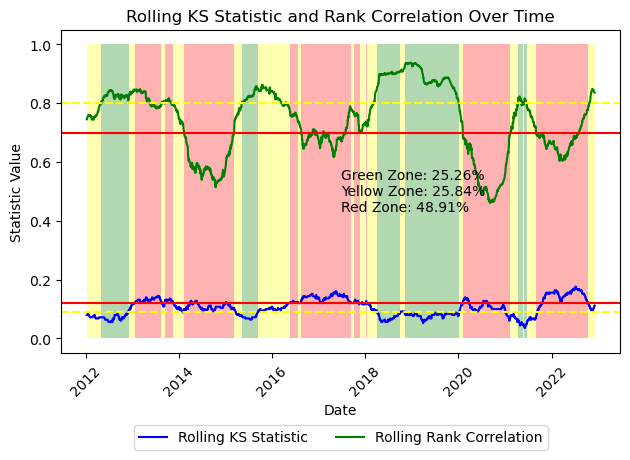

In [49]:
ind = 3

ks, rk = Miscellanea.compute_rolling_plat_statistic(mmm.hpl_with_hedge[:,ind], mmm.rtpl_sens_with_hedge[:,ind], 250)

# ks, rk = Miscellanea.compute_rolling_plat_statistic(mmm.hpl, mmm.rtpl_sens, 250)


print(ks.mean())
print(rk.mean())
print(mmm.cvar_with_hedge[:,ind].mean())


Miscellanea.plot_plat_statistics_with_zones(mmm.dates[250:],ks, rk)


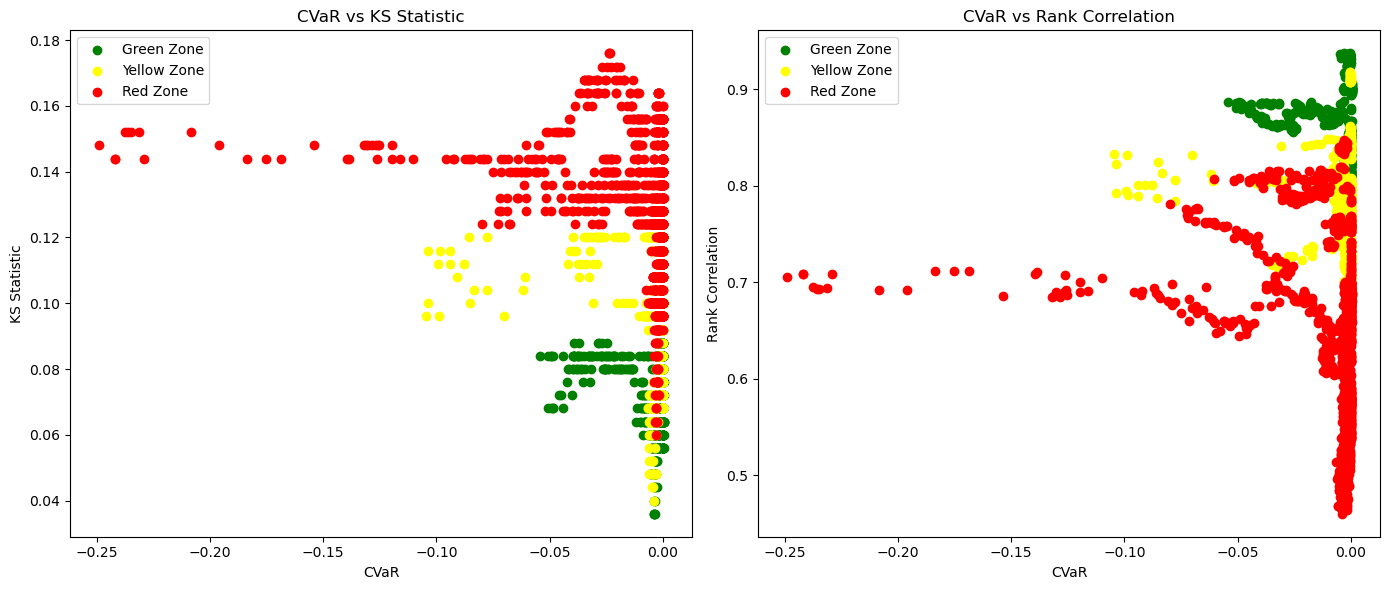

In [50]:
Miscellanea.plat_cvar_scatter(ks,rk,mmm.cvar_with_hedge[250:,ind])

In [51]:
# Data simulation dictionaries:
gaussian_model_dict = {
    'n_examples': 250,
    'n_components': 6,
    'gaussian_model_seed': 1234
}

base_scenario_dict = {
    'spot_indexes': [0, 2, 4],
    'spots': None,
    'vol_indexes': [1, 3, 5],
    'vols': None,
    'correlations': None,
    'rfr': 0.01,
    'divs': 0.0,
    'num_escen_correl_matrix': 250,
    'base_scenario': None
}

simulation_dict = {
    'shocks_generation_option': Enums.MktRisk_Scenarios_Generation_Option.EXPONENTIAL,
    'tf_generation_option': Enums.Include_Tensorflow_Calcs_option.YES,
    'simulation_seed': 5678,
    'Simulate_Var_Red_Payoff': Enums.Simulate_Var_Red_Payoff.YES
}


contract_data_dict = {
    'ttm': None,
    'generic_payoff': lambda indiv_strikes_value: \
                        lambda spot_t: \
                        (Scenario_Simulation.basket_option(spots_t= spot_t,
                            indiv_strikes=indiv_strikes_value,
                            option_strike=1.0,
                            tf_option=Enums.Include_Tensorflow_Calcs_option.YES)- \
                        Scenario_Simulation.basket_option(
                            spot_t,
                            indiv_strikes=indiv_strikes_value,
                            option_strike=1.1,
                            tf_option=Enums.Include_Tensorflow_Calcs_option.YES))/0.1,
    'payoff': None,
    'generic_closed_form_formula': lambda indiv_strikes_value, maturity: \
                            lambda spot_t, vol_t, rfr, divs, correl: \
                            (Option_formulas.BasketOptionVectorized(num_assets = 3,
                                initial_prices = spot_t, strike_prices = indiv_strikes_value,
                                gross_return_strike = 1.0, repo_rates = rfr*np.ones(3),
                                discount_rate = rfr, dividends = divs*np.ones(3),
                                volatilities = vol_t, correlations = correl,
                                time_to_maturity = maturity, IsCall = True) -
                            Option_formulas.BasketOptionVectorized(num_assets = 3,
                                initial_prices = spot_t, strike_prices = indiv_strikes_value,
                                gross_return_strike = 1.1, repo_rates = rfr*np.ones(3),
                                discount_rate = rfr, dividends = divs*np.ones(3),
                                volatilities = vol_t, correlations = correl,
                                time_to_maturity = maturity, IsCall = True))/0.1,
    'closed_form_formula': None,
    'indiv_strikes': None
}


training_data_generation_dict = {
        'gaussian_model_dict' : gaussian_model_dict,
        'base_scenario_dict': base_scenario_dict,
        'simulation_dict': simulation_dict,
        'contract_data_dict': contract_data_dict
    }

machine_learning_models_dict = {
    'nb_hidden_layers': 3,
    'nd_cells_hidden_layer': 64,
    'hidden_layer_activation': 'softplus',
    'output_layer_activation': 'linear',
    'batch_size': 32,
    'num_epochs_payoff_reset': 20,
    'num_epochs_daily_calc': 1,
    'num_training_examples_payoff_reset': 2**16,
    'num_training_examples_daily_calc': 2**14,
    'alpha' : 1.0,
    'verbose': 1,
    'MODELS_PATH': "MODELS/MODELS_MANAGEMENT/3YR_VR_LAMBDA_1_0/",
    'plat_analysis_subfolder': "COMPLETE/"
}


risk_management_dict = {
    'maturity_in_months_at_reset_dates': 36,
    'hedge_maturity_in_years': [0.5],
    'end_date': hist_data.index[-1],
    'initial_date': hist_data.index[gaussian_model_dict['n_examples'] + 10],
    'fut_hedge': [[True, True, True]],
    'call_hedge': [[False , False, False], [True, False, False], [True, True, False],[True, True, True]],
    'cvar_conf_level': 0.975
}     

mmm = ModelHandlers.plat_orquestrator(training_data_generation_dict, machine_learning_models_dict, risk_management_dict, hist_data) 


In [52]:
mmm.load_analysis_results()

Analysis results loaded from MODELS/MODELS_MANAGEMENT/3YR_VR_LAMBDA_1_0/COMPLETE/


In [53]:
Miscellanea.summarize_ongoing_plat_statistics(mmm, range(4))

,Unhedged,Delta Hedged,Delta + 1 vega Hedged,Delta + 2 vega Hedged,Delta + 3 vega Hedged
Avg CVaR,-0.144831,-0.042447,-0.024765,-0.017238,-0.007964
% Green,1.000000,0.926412,0.936248,0.888889,0.338434
% Yellow,0.000000,0.073588,0.063752,0.111111,0.232058
% Red,0.000000,0.000000,0.000000,0.000000,0.429508


0.10698579234972677
0.7949598402553322
-0.007964131872004579


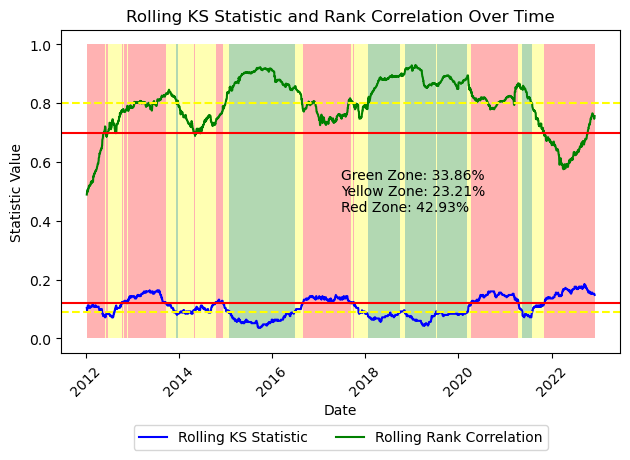

In [57]:
ind = 3

ks, rk = Miscellanea.compute_rolling_plat_statistic(mmm.hpl_with_hedge[:,ind], mmm.rtpl_sens_with_hedge[:,ind], 250)

# ks, rk = Miscellanea.compute_rolling_plat_statistic(mmm.hpl, mmm.rtpl_sens, 250)


print(ks.mean())
print(rk.mean())
print(mmm.cvar_with_hedge[:,ind].mean())


Miscellanea.plot_plat_statistics_with_zones(mmm.dates[250:],ks, rk)


In [ ]:
mmm = ModelHandlers.plat_orquestrator(training_data_generation_dict, machine_learning_models_dict, risk_management_dict, hist_data)

In [ ]:
mmm.load_analysis_results()

In [ ]:
ind = 3

ks, rk = Miscellanea.compute_rolling_plat_statistic(mmm.hpl_with_hedge[:,ind], mmm.rtpl_sens_with_hedge[:,ind], 250)

# ks, rk = Miscellanea.compute_rolling_plat_statistic(mmm.hpl, mmm.rtpl_sens, 250)


print(ks.mean())
print(rk.mean())
print(mmm.cvar_with_hedge[:,ind].mean())


Miscellanea.plot_plat_statistics_with_zones(mmm.dates[250:],ks, rk)


In [ ]:
mmm.run_plat_analysis()

In [62]:
# Data simulation dictionaries:
gaussian_model_dict = {
    'n_examples': 250,
    'n_components': 6,
    'gaussian_model_seed': 1234
}

base_scenario_dict = {
    'spot_indexes': [0, 2, 4],
    'spots': None,
    'vol_indexes': [1, 3, 5],
    'vols': None,
    'correlations': None,
    'rfr': 0.01,
    'divs': 0.0,
    'num_escen_correl_matrix': 250,
    'base_scenario': None
}

simulation_dict = {
    'shocks_generation_option': Enums.MktRisk_Scenarios_Generation_Option.EXPONENTIAL,
    'tf_generation_option': Enums.Include_Tensorflow_Calcs_option.YES,
    'simulation_seed': 5678,
    'Simulate_Var_Red_Payoff': Enums.Simulate_Var_Red_Payoff.YES
}


contract_data_dict = {
    'ttm': None,
    'generic_payoff': lambda indiv_strikes_value: \
                        lambda spot_t: \
                        (Scenario_Simulation.basket_option(spots_t= spot_t,
                            indiv_strikes=indiv_strikes_value,
                            option_strike=1.0,
                            tf_option=Enums.Include_Tensorflow_Calcs_option.YES)- \
                        Scenario_Simulation.basket_option(
                            spot_t,
                            indiv_strikes=indiv_strikes_value,
                            option_strike=1.1,
                            tf_option=Enums.Include_Tensorflow_Calcs_option.YES))/0.1,
    'payoff': None,
    'generic_closed_form_formula': lambda indiv_strikes_value, maturity: \
                            lambda spot_t, vol_t, rfr, divs, correl: \
                            (Option_formulas.BasketOptionVectorized(num_assets = 3,
                                initial_prices = spot_t, strike_prices = indiv_strikes_value,
                                gross_return_strike = 1.0, repo_rates = rfr*np.ones(3),
                                discount_rate = rfr, dividends = divs*np.ones(3),
                                volatilities = vol_t, correlations = correl,
                                time_to_maturity = maturity, IsCall = True) -
                            Option_formulas.BasketOptionVectorized(num_assets = 3,
                                initial_prices = spot_t, strike_prices = indiv_strikes_value,
                                gross_return_strike = 1.1, repo_rates = rfr*np.ones(3),
                                discount_rate = rfr, dividends = divs*np.ones(3),
                                volatilities = vol_t, correlations = correl,
                                time_to_maturity = maturity, IsCall = True))/0.1,
    'closed_form_formula': None,
    'indiv_strikes': None
}


training_data_generation_dict = {
        'gaussian_model_dict' : gaussian_model_dict,
        'base_scenario_dict': base_scenario_dict,
        'simulation_dict': simulation_dict,
        'contract_data_dict': contract_data_dict
    }

machine_learning_models_dict = {
    'nb_hidden_layers': 3,
    'nd_cells_hidden_layer': 64,
    'hidden_layer_activation': 'softplus',
    'output_layer_activation': 'linear',
    'batch_size': 32,
    'num_epochs_payoff_reset': 20,
    'num_epochs_daily_calc': 1,
    'num_training_examples_payoff_reset': 2**16,
    'num_training_examples_daily_calc': 2**14,
    'alpha' : 1.0,
    'verbose': 1,
    'MODELS_PATH': "MODELS/MODELS_MANAGEMENT/3YR_VR_LAMBDA_1_0/",
    'plat_analysis_subfolder': "0_5_YEARS_HEDGE/"
}

risk_management_dict = {
    'maturity_in_months_at_reset_dates': 36,
    'hedge_maturity_in_years': 0.5,
    'end_date': hist_data.index[-1],
    'initial_date': hist_data.index[gaussian_model_dict['n_examples'] + 10],
    'fut_hedge': [True, True, True],
    'call_hedge': [True, True, True]
}     
 

In [63]:
mmm = ModelHandlers.plat_orquestrator(training_data_generation_dict, machine_learning_models_dict, risk_management_dict, hist_data)

In [ ]:
mmm.train_models_for_all_dates()

In [64]:
mmm.run_plat_analysis()

Computing PLAT analysis for date 12-01-2011


TypeError: 'float' object is not iterable

In [60]:
mmm.load_analysis_results()

FileNotFoundError: [Errno 2] No such file or directory: 'MODELS/MODELS_MANAGEMENT/3YR_VR_LAMBDA_1_0/0_5_YEARS_HEDGE/cvar.npy'

In [ ]:
plt.plot(np.cumsum(mmm.hpl))
plt.plot(np.cumsum(mmm.rtpl_sens))


In [ ]:
Miscellanea.plot_plat_charts(mmm.hpl_with_hedge[0:250],mmm.rtpl_sens_with_hedge[0:250])

In [65]:
# Data simulation dictionaries:
gaussian_model_dict = {
    'n_examples': 250,
    'n_components': 6,
    'gaussian_model_seed': 1234
}

base_scenario_dict = {
    'spot_indexes': [0, 2, 4],
    'spots': None,
    'vol_indexes': [1, 3, 5],
    'vols': None,
    'correlations': None,
    'rfr': 0.01,
    'divs': 0.0,
    'num_escen_correl_matrix': 250,
    'base_scenario': None
}

simulation_dict = {
    'shocks_generation_option': Enums.MktRisk_Scenarios_Generation_Option.EXPONENTIAL,
    'tf_generation_option': Enums.Include_Tensorflow_Calcs_option.YES,
    'simulation_seed': 5678,
    'Simulate_Var_Red_Payoff': Enums.Simulate_Var_Red_Payoff.YES
}


contract_data_dict = {
    'ttm': None,
    'generic_payoff': lambda indiv_strikes_value: \
                        lambda spot_t: \
                        (Scenario_Simulation.basket_option(spots_t= spot_t,
                            indiv_strikes=indiv_strikes_value,
                            option_strike=1.0,
                            tf_option=Enums.Include_Tensorflow_Calcs_option.YES)- \
                        Scenario_Simulation.basket_option(
                            spot_t,
                            indiv_strikes=indiv_strikes_value,
                            option_strike=1.1,
                            tf_option=Enums.Include_Tensorflow_Calcs_option.YES))/0.1,
    'payoff': None,
    'generic_closed_form_formula': lambda indiv_strikes_value, maturity: \
                            lambda spot_t, vol_t, rfr, divs, correl: \
                            (Option_formulas.BasketOptionVectorized(num_assets = 3,
                                initial_prices = spot_t, strike_prices = indiv_strikes_value,
                                gross_return_strike = 1.0, repo_rates = rfr*np.ones(3),
                                discount_rate = rfr, dividends = divs*np.ones(3),
                                volatilities = vol_t, correlations = correl,
                                time_to_maturity = maturity, IsCall = True) -
                            Option_formulas.BasketOptionVectorized(num_assets = 3,
                                initial_prices = spot_t, strike_prices = indiv_strikes_value,
                                gross_return_strike = 1.1, repo_rates = rfr*np.ones(3),
                                discount_rate = rfr, dividends = divs*np.ones(3),
                                volatilities = vol_t, correlations = correl,
                                time_to_maturity = maturity, IsCall = True))/0.1,
    'closed_form_formula': None,
    'indiv_strikes': None
}


training_data_generation_dict = {
        'gaussian_model_dict' : gaussian_model_dict,
        'base_scenario_dict': base_scenario_dict,
        'simulation_dict': simulation_dict,
        'contract_data_dict': contract_data_dict
    }

machine_learning_models_dict = {
    'nb_hidden_layers': 3,
    'nd_cells_hidden_layer': 64,
    'hidden_layer_activation': 'softplus',
    'output_layer_activation': 'linear',
    'batch_size': 32,
    'num_epochs_payoff_reset': 20,
    'num_epochs_daily_calc': 1,
    'num_training_examples_payoff_reset': 2**16,
    'num_training_examples_daily_calc': 2**14,
    'alpha' : 0.0,
    'verbose': 1,
    'MODELS_PATH': "MODELS/MODELS_MANAGEMENT/3YR_VR_LAMBDA_0_0/",
    'plat_analysis_subfolder': "0_5_YEARS_HEDGE/"
}


risk_management_dict = {
    'maturity_in_months_at_reset_dates': 36,
    'hedge_maturity_in_years': [0.5],
    'end_date': hist_data.index[-1],
    'initial_date': hist_data.index[gaussian_model_dict['n_examples'] + 10],
    'fut_hedge': [[True, True, True]],
    'call_hedge': [[False, False, False], [True, False, False], [True, True, False],[True, True, True]],
    'cvar_conf_level': 0.975
}     

mmm = ModelHandlers.plat_orquestrator(training_data_generation_dict, machine_learning_models_dict, risk_management_dict, hist_data) 


In [ ]:
mmm.train_models_for_all_dates()

In [ ]:
mmm.run_plat_analysis()

In [66]:
mmm.load_analysis_results()  

Analysis results loaded from MODELS/MODELS_MANAGEMENT/3YR_VR_LAMBDA_0_0/0_5_YEARS_HEDGE/


In [67]:
df2 = Miscellanea.summarize_ongoing_plat_statistics(mmm, range(4))

df2


,Unhedged,Delta Hedged,Delta + 1 vega Hedged,Delta + 2 vega Hedged,Delta + 3 vega Hedged
Avg CVaR,-0.144969,-0.042472,-0.024836,-0.017246,-0.007989
% Green,1.000000,0.910383,0.907104,0.790528,0.181056
% Yellow,0.000000,0.041166,0.024772,0.105647,0.224772
% Red,0.000000,0.048452,0.068124,0.103825,0.594171


In [68]:
pd.options.display.float_format = '{:.4f}'.format

columns = ['Unhedged', '$\Delta$', '$\Delta$1V', '$\Delta$2V', '$\Delta$3V']

index = pd.MultiIndex.from_tuples([('CVaR Results', 'Avg CVaR'), ('No VR $\lambda=1.0$', '\% Green'), ('No VR $\lambda=1.0$', '\% Yellow'), 
                                   ('No VR $\lambda=1.0$','\% Red')])

df1.index = index

df1

index = pd.MultiIndex.from_tuples([('CVaR Results', 'Avg CVaR'), ('VR $\lambda=0.0$', '\% Green'), ('VR $\lambda=0.0$', '\% Yellow'), 
                                   ('VR $\lambda=0.0$','\% Red')])

df2.index= index

df2.drop('CVaR Results', inplace = True)

df = pd.concat([df1,df2])
df.columns = columns

display(df)

print(df.to_latex(float_format="{:.3f}".format))
                                  

Unhedged  $\Delta$  $\Delta$1V  $\Delta$2V  \
CVaR Results        Avg CVaR    -0.1448   -0.0424     -0.0248     -0.0172   
No VR $\lambda=1.0$ \% Green     1.0000    0.9341      0.9133      0.9118   
                    \% Yellow    0.0000    0.0444      0.0506      0.0459   
                    \% Red       0.0000    0.0215      0.0361      0.0423   
VR $\lambda=0.0$    \% Green     1.0000    0.9104      0.9071      0.7905   
                    \% Yellow    0.0000    0.0412      0.0248      0.1056   
                    \% Red       0.0000    0.0485      0.0681      0.1038   

                               $\Delta$3V  
CVaR Results        Avg CVaR      -0.0080  
No VR $\lambda=1.0$ \% Green       0.3960  
                    \% Yellow      0.3337  
                    \% Red         0.2703  
VR $\lambda=0.0$    \% Green       0.1811  
                    \% Yellow      0.2248  
                    \% Red         0.5942

\begin{tabular}{llrrrrr}
\toprule
 &  & Unhedged & $\Delta$ & $\Delta$1V & $\Delta$2V & $\Delta$3V \\
\midrule
CVaR Results & Avg CVaR & -0.145 & -0.042 & -0.025 & -0.017 & -0.008 \\
\cline{1-7}
\multirow[t]{3}{*}{No VR $\lambda=1.0$} & \% Green & 1.000 & 0.934 & 0.913 & 0.912 & 0.396 \\
 & \% Yellow & 0.000 & 0.044 & 0.051 & 0.046 & 0.334 \\
 & \% Red & 0.000 & 0.021 & 0.036 & 0.042 & 0.270 \\
\cline{1-7}
\multirow[t]{3}{*}{VR $\lambda=0.0$} & \% Green & 1.000 & 0.910 & 0.907 & 0.791 & 0.181 \\
 & \% Yellow & 0.000 & 0.041 & 0.025 & 0.106 & 0.225 \\
 & \% Red & 0.000 & 0.048 & 0.068 & 0.104 & 0.594 \\
\cline{1-7}
\bottomrule
\end{tabular}



0.048405100182149365
0.9540869550466952
-0.04247233506307668


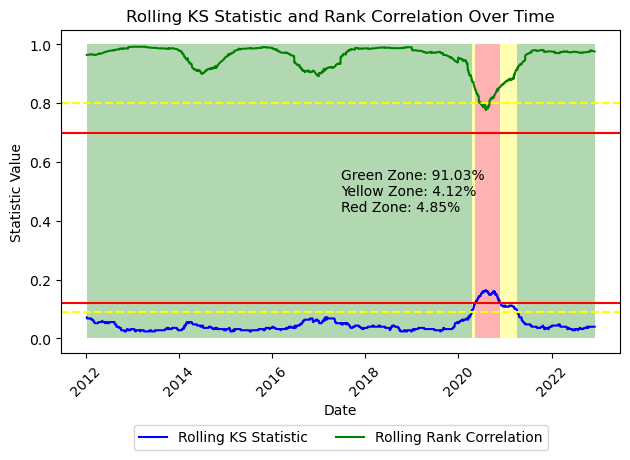

In [69]:
ind = 0

ks, rk = Miscellanea.compute_rolling_plat_statistic(mmm.hpl_with_hedge[:,ind], mmm.rtpl_sens_with_hedge[:,ind], 250)

# ks, rk = Miscellanea.compute_rolling_plat_statistic(mmm.hpl, mmm.rtpl_sens, 250)


print(ks.mean())
print(rk.mean())
print(mmm.cvar_with_hedge[:,ind].mean())


Miscellanea.plot_plat_statistics_with_zones(mmm.dates[250:],ks, rk)

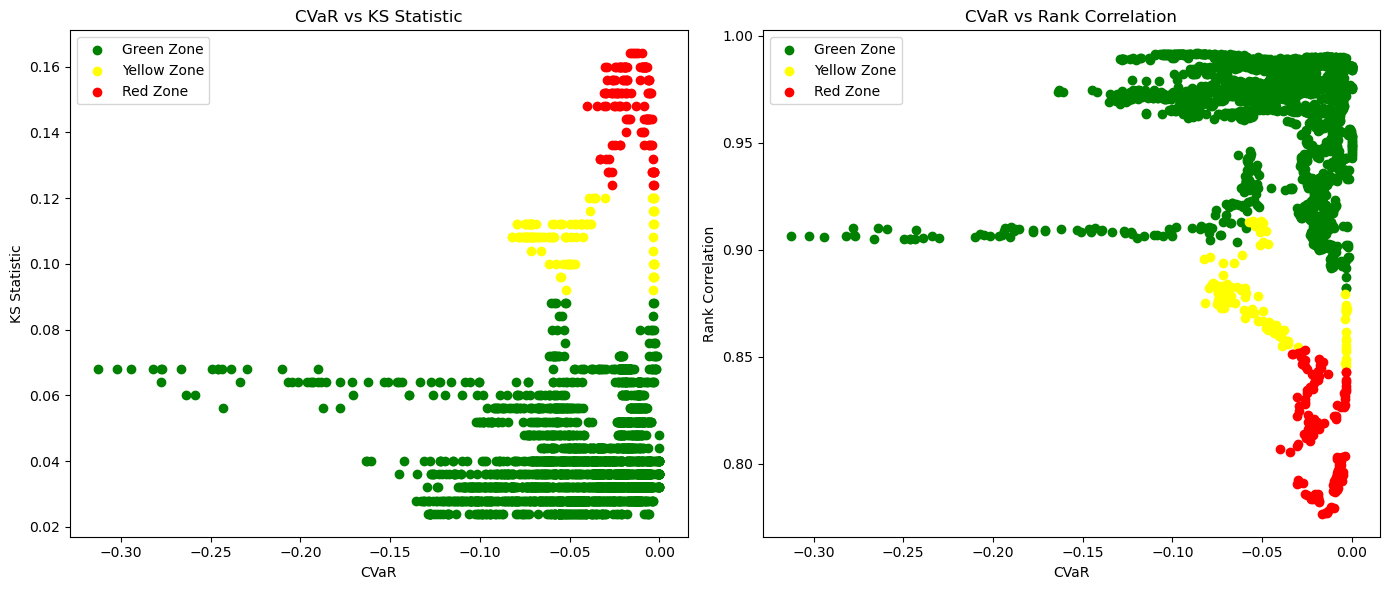

In [70]:
Miscellanea.plat_cvar_scatter(ks,rk,mmm.cvar_with_hedge[250:,ind])

In [ ]:
mmm.init_and_maturity_dates